# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name = 'input_real')
    input_z    = tf.placeholder(tf.float32, [None, z_dim], name = 'input_z')
    learning_rate = tf.placeholder(tf.float32, [], name = 'laerning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [14]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    keep_prob = 0.8
    with tf.variable_scope('discriminator', reuse = reuse):
        #image shape equal 28 by 28 by channels_num
        x = tf.layers.conv2d(images, 32, 5, strides = 2, padding = 'same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.maximum(alpha * x, x)
        x = tf.nn.dropout(x, keep_prob)
        # looks like no alpha there, and we get ouput 14 by 14 by 32
        
        x = tf.layers.conv2d(x, 64, 5, strides = 2, padding = 'same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training = True)
        x = tf.maximum(alpha * x, x)
        x = tf.nn.dropout(x, keep_prob)
        # 7 by 7 by 64
        
        x = tf.layers.conv2d(x, 128, 5, strides = 2, padding = 'same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training = True)
        x = tf.maximum(alpha * x, x)
        x = tf.nn.dropout(x, keep_prob)
        #4 by 4 by 128'
        
        x = tf.layers.conv2d(x, 256, 5, strides = 2, padding = 'same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training = True)
        x = tf.maximum(alpha * x, x)
        x = tf.nn.dropout(x, keep_prob)
        # 2 by 2 by 256
        
        #x = tf.layers.conv2d(x, 512, 4, strides = 2, padding = 'same')
        #x = tf.layers.batch_normalization(x, training = True)
        #x = tf.maximum(alpha * x, x)
        # 2 by 2 by 512
        
        flatten = tf.reshape(x, (-1, 2*2*256))
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [17]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    keep_prob = 0.8
    with tf.variable_scope('generator', reuse = not is_train):
        x = tf.layers.dense(z, 4*4*512)
        x = tf.reshape(x, (-1, 4, 4, 512))
        x = tf.layers.batch_normalization(x, training = True)
        x = tf.maximum(alpha * x, x)
        # now we get 4 by 4 by 256
        
        #x = tf.layers.conv2d_transpose(x, 256, 2, strides = 2, padding = 'valid')
        #x = tf.layers.batch_normalization(x, training = True)
        #x = tf.maximum(alpha * x, x)
        #4 by 4 by 256
        
        x = tf.layers.conv2d_transpose(x, 128, 4, strides = 1, padding = 'valid',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training = True)
        x = tf.maximum(alpha * x, x)
        x = tf.nn.dropout(x, keep_prob)
        # 7 by 7 by 128
        
        x = tf.layers.conv2d_transpose(x, 64, 5, strides = 2, padding = 'same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training = True)
        x = tf.maximum(alpha * x, x)
        x = tf.nn.dropout(x, keep_prob)
        #14 by 14 by 64
        
        x = tf.layers.conv2d_transpose(x, 32, 5, strides = 2, padding = 'same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training = True)
        x = tf.maximum(alpha * x, x)
        x = tf.nn.dropout(x, keep_prob)
        #28 by 28 by dim
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 3, 1, 'same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


In [23]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    keep_prob = 0.8
    with tf.variable_scope('generator', reuse = not is_train):
        x = tf.layers.dense(z, 2*2*512)
        x = tf.reshape(x, (-1, 2, 2, 512))
        x = tf.layers.batch_normalization(x, training = True)
        x = tf.maximum(alpha * x, x)
        # now we get 2 2 512
        
        x = tf.layers.conv2d_transpose(x, 256, 2, strides = 2, padding = 'valid',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training = True)
        x = tf.maximum(alpha * x, x)
        x = tf.nn.dropout(x, keep_prob)# add dropout
        #4 by 4 by 256
        
        x = tf.layers.conv2d_transpose(x, 128, 4, strides = 1, padding = 'valid',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training = True)
        x = tf.maximum(alpha * x, x)
        x = tf.nn.dropout(x, keep_prob)
        # 7 by 7 by 128
        
        x = tf.layers.conv2d_transpose(x, 64, 5, strides = 2, padding = 'same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training = True)
        x = tf.maximum(alpha * x, x)
        x = tf.nn.dropout(x, keep_prob)
        #14 by 14 by 64
        
        x = tf.layers.conv2d_transpose(x, 32, 5, strides = 2, padding = 'same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training = True)
        x = tf.maximum(alpha * x, x)
        x = tf.nn.dropout(x, keep_prob)
        #28 by 28 by dim
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 3, 1, 'same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [24]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_out_real, d_logits_real = discriminator(input_real)
    d_out_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, labels = tf.ones_like(d_logits_real) * (1 - smooth)))
    #cause we want real to be real
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.zeros_like(d_logits_fake)))
    #cause we want fake to be classified to fake
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.ones_like(d_logits_fake)))
        
    d_loss = d_loss_fake + d_loss_real
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [25]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    v_vars = tf.trainable_variables()
    d_vars = [var for var in v_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in v_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [27]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    if (data_image_mode == 'L'):
        out_channel_dim = 1
    else :
        out_channel_dim = 3
    
    #saver = tf.train.Saver()
    steps = 0
    
    inputs_real, inputs_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size): #batch_images
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images,
                                               inputs_z: batch_z,
                                               learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z,
                                               inputs_real: batch_images,
                                               learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z,
                                               inputs_real: batch_images,
                                               learn_rate: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    gen_samples = sess.run(
                                   generator(inputs_z, out_channel_dim, is_train=False),
                                   feed_dict={inputs_z: batch_z})
                    x = show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)

        #saver.save(sess, './checkpoints/generator.ckpt')
                
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 2.8276... Generator Loss: 0.3708
Epoch 1/2... Discriminator Loss: 1.5397... Generator Loss: 1.1931
Epoch 1/2... Discriminator Loss: 1.6055... Generator Loss: 0.7332
Epoch 1/2... Discriminator Loss: 1.4654... Generator Loss: 1.4714
Epoch 1/2... Discriminator Loss: 1.3988... Generator Loss: 0.9606
Epoch 1/2... Discriminator Loss: 1.0094... Generator Loss: 1.2000
Epoch 1/2... Discriminator Loss: 1.9145... Generator Loss: 2.7054
Epoch 1/2... Discriminator Loss: 0.9952... Generator Loss: 1.0930
Epoch 1/2... Discriminator Loss: 2.1451... Generator Loss: 0.5633
Epoch 1/2... Discriminator Loss: 1.3335... Generator Loss: 0.8244


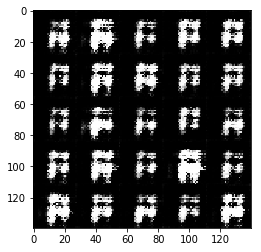

Epoch 1/2... Discriminator Loss: 0.9142... Generator Loss: 1.3945
Epoch 1/2... Discriminator Loss: 1.5105... Generator Loss: 1.2933
Epoch 1/2... Discriminator Loss: 1.3937... Generator Loss: 0.8797
Epoch 1/2... Discriminator Loss: 1.3761... Generator Loss: 0.8616
Epoch 1/2... Discriminator Loss: 1.5727... Generator Loss: 0.7900
Epoch 1/2... Discriminator Loss: 1.5398... Generator Loss: 0.7874
Epoch 1/2... Discriminator Loss: 1.3789... Generator Loss: 0.8945
Epoch 1/2... Discriminator Loss: 1.3209... Generator Loss: 0.9478
Epoch 1/2... Discriminator Loss: 1.3490... Generator Loss: 0.9715
Epoch 1/2... Discriminator Loss: 1.3038... Generator Loss: 0.8524


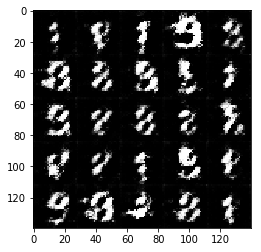

Epoch 1/2... Discriminator Loss: 1.2529... Generator Loss: 0.9385
Epoch 1/2... Discriminator Loss: 1.2693... Generator Loss: 0.9553
Epoch 1/2... Discriminator Loss: 1.2458... Generator Loss: 0.8867
Epoch 1/2... Discriminator Loss: 1.5512... Generator Loss: 1.0033
Epoch 1/2... Discriminator Loss: 1.4452... Generator Loss: 0.8706
Epoch 1/2... Discriminator Loss: 1.4791... Generator Loss: 0.7487
Epoch 1/2... Discriminator Loss: 1.6100... Generator Loss: 0.7546
Epoch 1/2... Discriminator Loss: 1.4747... Generator Loss: 0.7828
Epoch 1/2... Discriminator Loss: 1.4175... Generator Loss: 0.9440
Epoch 1/2... Discriminator Loss: 1.3793... Generator Loss: 0.9582


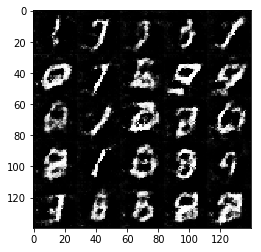

Epoch 1/2... Discriminator Loss: 1.4292... Generator Loss: 0.7900
Epoch 1/2... Discriminator Loss: 1.4499... Generator Loss: 0.8177
Epoch 1/2... Discriminator Loss: 1.2881... Generator Loss: 0.9302
Epoch 1/2... Discriminator Loss: 1.4572... Generator Loss: 0.8125
Epoch 1/2... Discriminator Loss: 1.4022... Generator Loss: 0.7669
Epoch 1/2... Discriminator Loss: 1.3402... Generator Loss: 0.8420
Epoch 1/2... Discriminator Loss: 1.3234... Generator Loss: 0.8581
Epoch 1/2... Discriminator Loss: 1.3579... Generator Loss: 0.8730
Epoch 1/2... Discriminator Loss: 1.4235... Generator Loss: 0.8260
Epoch 1/2... Discriminator Loss: 1.3350... Generator Loss: 0.8377


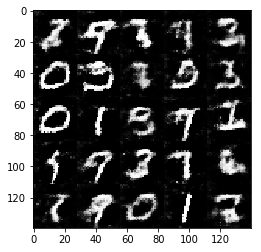

Epoch 1/2... Discriminator Loss: 1.3210... Generator Loss: 0.8056
Epoch 1/2... Discriminator Loss: 1.2838... Generator Loss: 0.9767
Epoch 1/2... Discriminator Loss: 1.4135... Generator Loss: 0.8665
Epoch 1/2... Discriminator Loss: 1.3477... Generator Loss: 0.9140
Epoch 1/2... Discriminator Loss: 1.4123... Generator Loss: 0.8976
Epoch 1/2... Discriminator Loss: 1.3693... Generator Loss: 0.9156
Epoch 2/2... Discriminator Loss: 1.3052... Generator Loss: 0.8071
Epoch 2/2... Discriminator Loss: 1.3998... Generator Loss: 0.6529
Epoch 2/2... Discriminator Loss: 1.4228... Generator Loss: 0.8510
Epoch 2/2... Discriminator Loss: 1.3342... Generator Loss: 0.8958


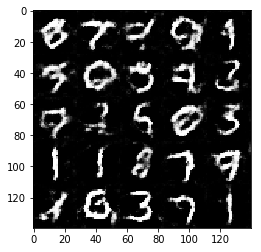

Epoch 2/2... Discriminator Loss: 1.3453... Generator Loss: 0.9033
Epoch 2/2... Discriminator Loss: 1.4818... Generator Loss: 0.7669
Epoch 2/2... Discriminator Loss: 1.4304... Generator Loss: 0.7845
Epoch 2/2... Discriminator Loss: 1.3411... Generator Loss: 0.7610
Epoch 2/2... Discriminator Loss: 1.4613... Generator Loss: 0.7012
Epoch 2/2... Discriminator Loss: 1.3711... Generator Loss: 0.8617
Epoch 2/2... Discriminator Loss: 1.2810... Generator Loss: 0.9857
Epoch 2/2... Discriminator Loss: 1.3674... Generator Loss: 0.8010
Epoch 2/2... Discriminator Loss: 1.3500... Generator Loss: 0.6957
Epoch 2/2... Discriminator Loss: 1.3099... Generator Loss: 0.9954


Epoch 2/2... Discriminator Loss: 1.3439... Generator Loss: 0.8383
Epoch 2/2... Discriminator Loss: 1.3508... Generator Loss: 0.9176
Epoch 2/2... Discriminator Loss: 1.3554... Generator Loss: 0.8594
Epoch 2/2... Discriminator Loss: 1.2797... Generator Loss: 0.8721
Epoch 2/2... Discriminator Loss: 1.3535... Generator Loss: 0.7833
Epoch 2/2... Discriminator Loss: 1.4265... Generator Loss: 0.5965
Epoch 2/2... Discriminator Loss: 1.2846... Generator Loss: 0.8712
Epoch 2/2... Discriminator Loss: 1.3544... Generator Loss: 1.2733
Epoch 2/2... Discriminator Loss: 1.3142... Generator Loss: 0.9221
Epoch 2/2... Discriminator Loss: 1.2444... Generator Loss: 0.8737


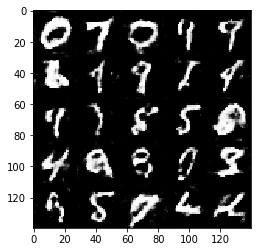

Epoch 2/2... Discriminator Loss: 1.3678... Generator Loss: 0.6334
Epoch 2/2... Discriminator Loss: 1.3965... Generator Loss: 0.9084
Epoch 2/2... Discriminator Loss: 1.3803... Generator Loss: 0.7825
Epoch 2/2... Discriminator Loss: 1.3340... Generator Loss: 0.7670
Epoch 2/2... Discriminator Loss: 1.3370... Generator Loss: 0.9651
Epoch 2/2... Discriminator Loss: 1.4257... Generator Loss: 0.8386
Epoch 2/2... Discriminator Loss: 1.2786... Generator Loss: 1.0116
Epoch 2/2... Discriminator Loss: 1.3779... Generator Loss: 0.6770
Epoch 2/2... Discriminator Loss: 1.2791... Generator Loss: 0.7702
Epoch 2/2... Discriminator Loss: 1.3505... Generator Loss: 0.9243


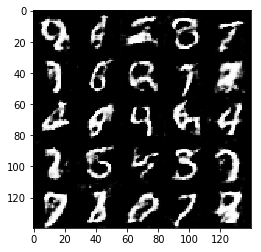

Epoch 2/2... Discriminator Loss: 1.3574... Generator Loss: 0.8067
Epoch 2/2... Discriminator Loss: 1.3412... Generator Loss: 0.7820
Epoch 2/2... Discriminator Loss: 1.3088... Generator Loss: 1.0887
Epoch 2/2... Discriminator Loss: 1.3397... Generator Loss: 1.1285
Epoch 2/2... Discriminator Loss: 1.3104... Generator Loss: 0.8522
Epoch 2/2... Discriminator Loss: 1.2445... Generator Loss: 0.8247
Epoch 2/2... Discriminator Loss: 1.3328... Generator Loss: 1.1058
Epoch 2/2... Discriminator Loss: 1.3231... Generator Loss: 0.9283
Epoch 2/2... Discriminator Loss: 1.2975... Generator Loss: 0.8939
Epoch 2/2... Discriminator Loss: 1.3108... Generator Loss: 1.1515


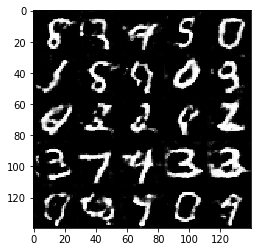

Epoch 2/2... Discriminator Loss: 1.4680... Generator Loss: 1.4081
Epoch 2/2... Discriminator Loss: 1.2985... Generator Loss: 0.9614
Epoch 2/2... Discriminator Loss: 1.2780... Generator Loss: 1.0186


In [28]:
batch_size = 128
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 1.8374... Generator Loss: 1.4078
Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 1.5239... Generator Loss: 0.9158
Epoch 1/1... Discriminator Loss: 0.9451... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.2287... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.5788... Generator Loss: 0.5009
Epoch 1/1... Discriminator Loss: 1.6195... Generator Loss: 0.9329
Epoch 1/1... Discriminator Loss: 1.5691... Generator Loss: 0.6405
Epoch 1/1... Discriminator Loss: 1.8207... Generator Loss: 1.4582
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.7548


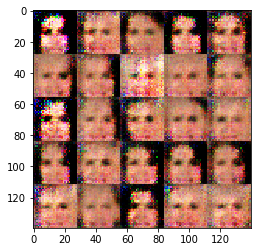

Epoch 1/1... Discriminator Loss: 1.5790... Generator Loss: 1.5208
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.2408... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 1.7638... Generator Loss: 0.5549
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.6002
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.6399... Generator Loss: 0.5704
Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.8901
Epoch 1/1... Discriminator Loss: 1.5066... Generator Loss: 0.5225


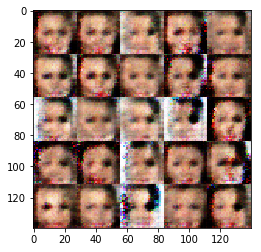

Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.8535
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.9038
Epoch 1/1... Discriminator Loss: 1.5016... Generator Loss: 0.5860
Epoch 1/1... Discriminator Loss: 1.5619... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.4889... Generator Loss: 0.8182
Epoch 1/1... Discriminator Loss: 1.4841... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.7691


Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 1.5038... Generator Loss: 0.8538
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.7147


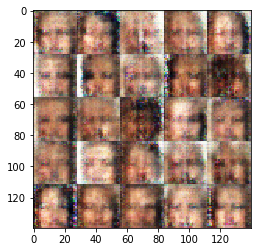

Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.8261
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.8452
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.8437


Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.8956
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.8368


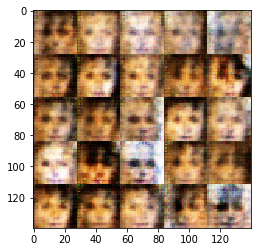

Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.4732... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.8910
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.8301


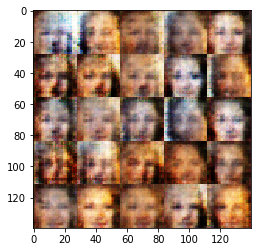

Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.9098
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.7548


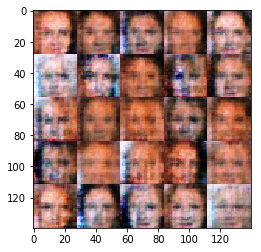

Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.9105
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.7993


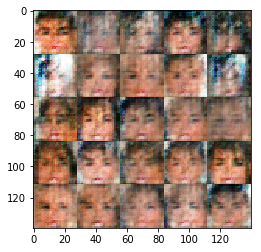

Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.8446
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.8459
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.7451


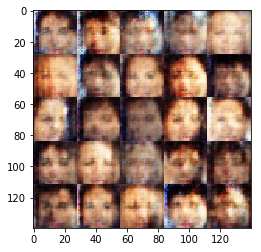

Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.8504
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7534


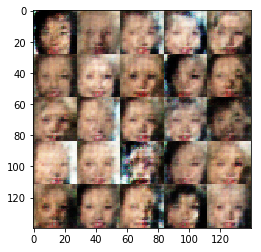

Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.8389
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.8751
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.8932
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.8043


Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.8202
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.9173
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.9194
Epoch 1/1... Discriminator Loss: 1.4767... Generator Loss: 0.8745
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.8451
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.7750


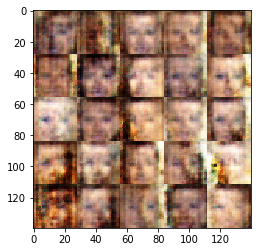

Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.8200
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.8018


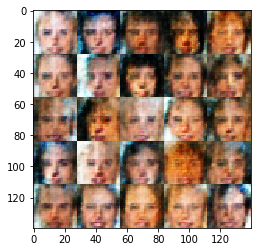

Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.8439


Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.7518


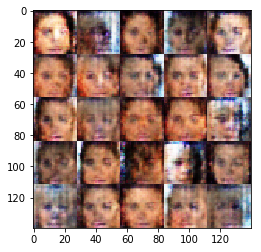

Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.8443
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.8366
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.7688


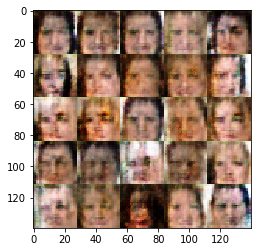

Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.8390
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.8216


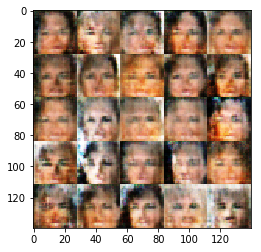

Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.8442
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.8724
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.7738


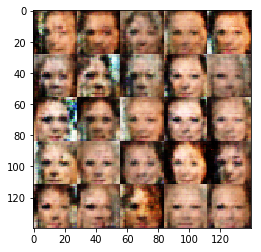

Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7320


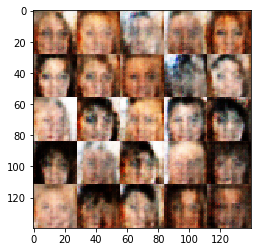

Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.8893
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7779


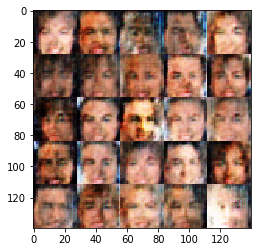

Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.8240


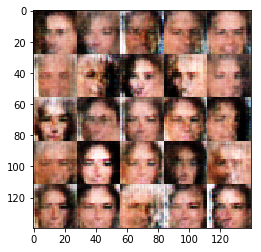

Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.8595
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.7682


Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.8631
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7946


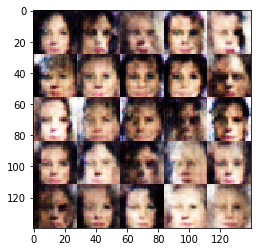

Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.8833
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.7454
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.7339


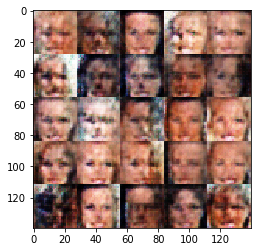

Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.8372
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7929


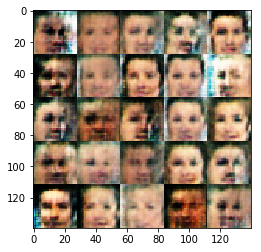

Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.7589


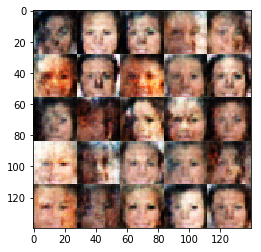

Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.8373
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.7896


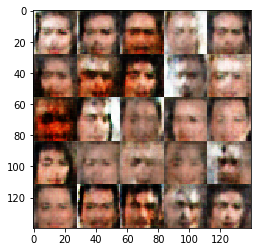

Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.7499


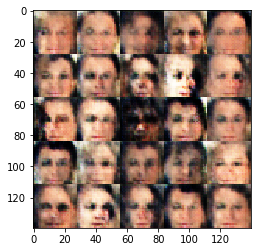

Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.7844


Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.7494


Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.8199


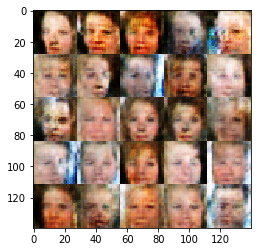

Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.8102
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.8503
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.8284
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.7639


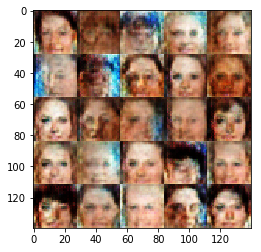

Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.8529


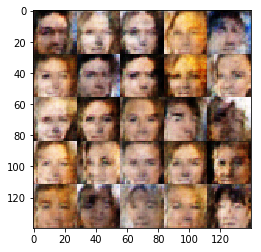

Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.7806


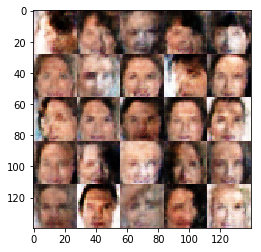

Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.8636
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.8198
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.7919


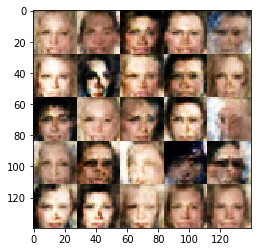

Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.8392
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.8197


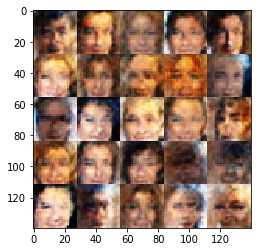

Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7841


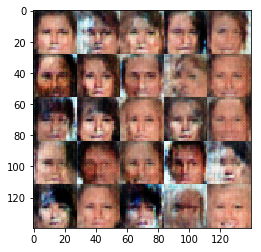

Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.8134
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.8229


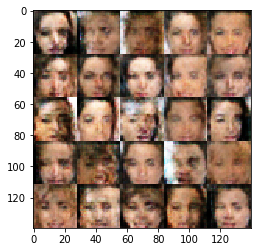

Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.8560
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.7653


Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.8651
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.8561


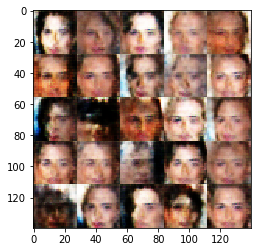

Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.8083
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.7953


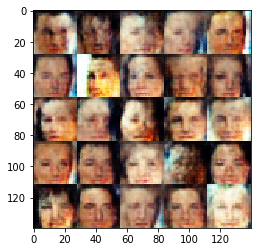

Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.8268
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.8092


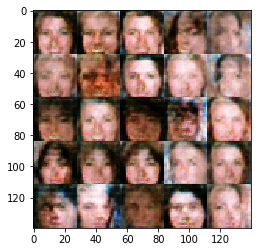

Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.8433
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.8238
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.7921


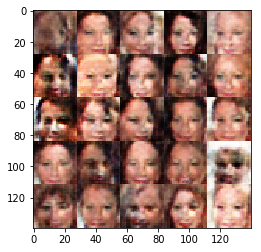

Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.7673


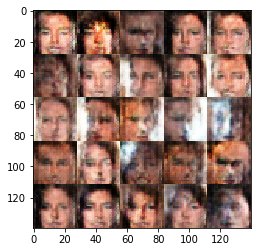

Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.8635


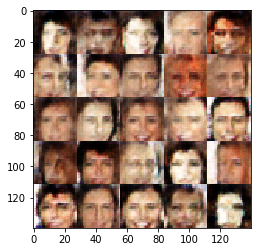

Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.7948
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.8329
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.8010


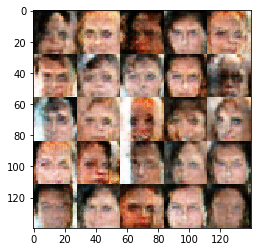

Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7956


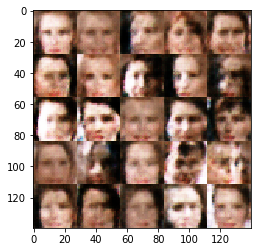

Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.8028


Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.7870


Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.8655
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.8107


Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.8101


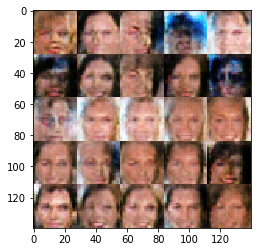

Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7918


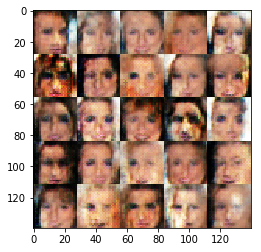

Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.8407
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.7806


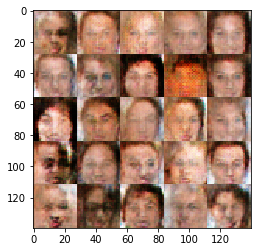

Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.8607
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7731


Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.8111


Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.8076
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.8060


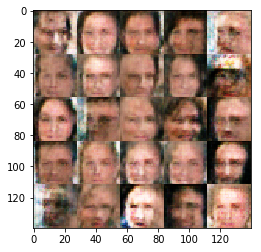

Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.8261


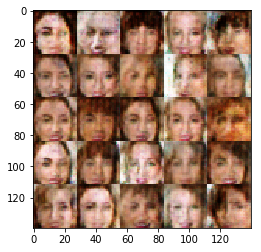

Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.8425
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7925


Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.8444
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.8256


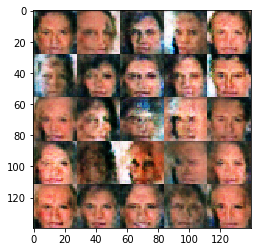

Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.8095
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.8371
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.7433


Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.8138


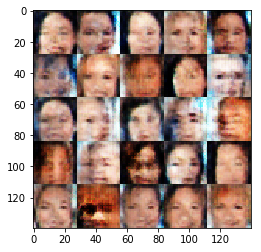

Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.7339


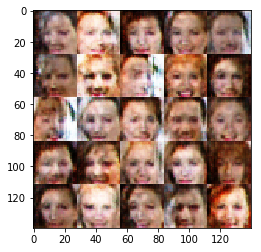

Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.7966


In [29]:
batch_size = 32
z_dim = 128
learning_rate = 0.001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。